# Analisis Exploratorio de los datos


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix,roc_auc_score,balanced_accuracy_score,ConfusionMatrixDisplay,roc_curve,auc
from sklearn.preprocessing import label_binarize


In [3]:
#-- Cargar los datos---#
df=pd.read_csv('datos_miniproyecto1.csv',sep=';')
df = df.rename(columns={'Target': 'Estado'})
df

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Estado
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


In [4]:
print(df.columns.values)

['Marital status' 'Application mode' 'Application order' 'Course'
 'Daytime/evening attendance\t' 'Previous qualification'
 'Previous qualification (grade)' 'Nacionality' "Mother's qualification"
 "Father's qualification" "Mother's occupation" "Father's occupation"
 'Admission grade' 'Displaced' 'Educational special needs' 'Debtor'
 'Tuition fees up to date' 'Gender' 'Scholarship holder'
 'Age at enrollment' 'International' 'Curricular units 1st sem (credited)'
 'Curricular units 1st sem (enrolled)'
 'Curricular units 1st sem (evaluations)'
 'Curricular units 1st sem (approved)' 'Curricular units 1st sem (grade)'
 'Curricular units 1st sem (without evaluations)'
 'Curricular units 2nd sem (credited)'
 'Curricular units 2nd sem (enrolled)'
 'Curricular units 2nd sem (evaluations)'
 'Curricular units 2nd sem (approved)' 'Curricular units 2nd sem (grade)'
 'Curricular units 2nd sem (without evaluations)' 'Unemployment rate'
 'Inflation rate' 'GDP' 'Estado']


In [5]:
print(df.shape)

(4424, 37)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

In [7]:
Cat_vars = df[['Marital status', 'Application mode',                                 
   'Application order', 'Course', 'Daytime/evening attendance\t',
    'Previous qualification', 'Previous qualification (grade)',
    'Nacionality', 'Mother\'s qualification', 'Father\'s qualification',
    'Mother\'s occupation', 'Father\'s occupation','Displaced',                                       
   'Educational special needs',                       
  'Debtor' ,                                        
  'Tuition fees up to date'  ,                        
  'Gender'  ,                                          
  'Scholarship holder','International','Estado']] 
Cat_vars= Cat_vars.astype('object')                              

Num_vars = df[['Previous qualification (grade)','Admission grade','Age at enrollment','Curricular units 1st sem (credited)',
            'Curricular units 1st sem (enrolled)','Curricular units 1st sem (evaluations)','Curricular units 1st sem (approved)','Curricular units 1st sem (grade)','Curricular units 1st sem (without evaluations)','Curricular units 2nd sem (credited)',
            'Curricular units 2nd sem (enrolled)','Curricular units 2nd sem (evaluations)','Curricular units 2nd sem (approved)','Curricular units 2nd sem (grade)','Curricular units 2nd sem (without evaluations)',
            'Unemployment rate', 'Inflation rate', 'GDP']]


In [8]:
Num_vars.describe()

,Previous qualification (grade),Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,132.613314,126.978119,23.265145,0.709991,6.270570,8.299051,4.706600,10.640822,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,13.188332,14.482001,7.587816,2.360507,2.480178,4.179106,3.094238,4.843663,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,95.000000,95.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,125.000000,117.900000,19.000000,0.000000,5.000000,6.000000,3.000000,11.000000,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,133.100000,126.100000,20.000000,0.000000,6.000000,8.000000,5.000000,12.285714,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,140.000000,134.800000,25.000000,0.000000,7.000000,10.000000,6.000000,13.400000,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,190.000000,190.000000,70.000000,20.000000,26.000000,45.000000,26.000000,18.875000,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


In [9]:
Cat_vars.describe(include='object')

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,International,Estado
count,4424,4424,4424,4424,4424,4424,4424.0,4424,4424,4424,4424,4424,4424,4424,4424,4424,4424,4424,4424,4424
unique,6,18,8,17,2,17,101.0,21,29,34,32,46,2,2,2,2,2,2,2,3
top,1,1,1,9500,1,1,133.1,1,1,37,9,9,1,0,0,1,0,0,0,Graduate
freq,3919,1708,3026,766,3941,3717,491.0,4314,1069,1209,1577,1010,2426,4373,3921,3896,2868,3325,4314,2209


# Variables respuesta

Para el proyecto nuestras variables respuesta o "Target" serán __Estado__ y __GDP__

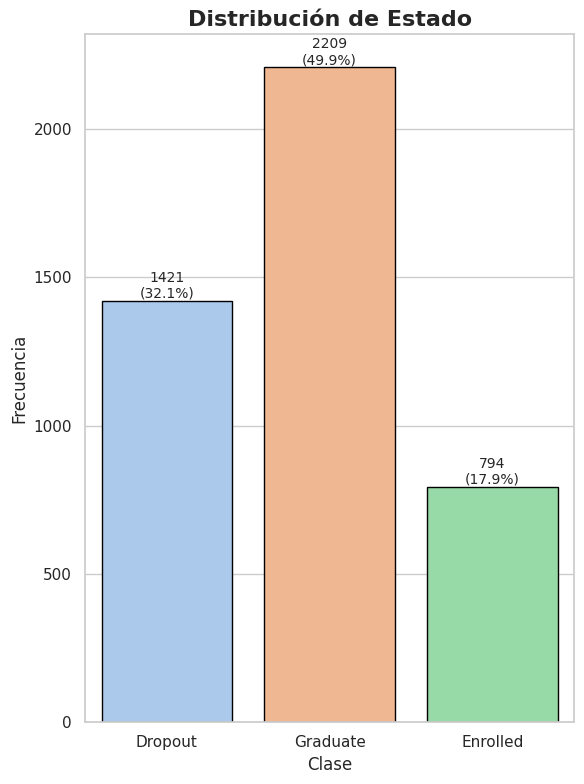

In [10]:
sns.set(style="whitegrid", palette="pastel", font_scale=1)

plt.figure(figsize=(6, 8))
ax = sns.countplot(data=df, x='Estado', hue='Estado', legend=False,
                   palette='pastel', edgecolor='black')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}\n({height/len(df)*100:.1f}%)',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=10)
plt.title('Distribución de Estado', fontsize=16, weight='bold')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Con este grafico podemos apreciar la distribución de clases de nuestra variable __Estado__, la cual presenta un gran desbalance.
Mientras que la clase **Graduate** representa casi un 50% de los datos, la variable **Enrolled** apenas alcance un 18% con 794 registros.
Y aunque la clase **Dropout** tiene más de 1200 registros apenas cubre un 30% de los datos.

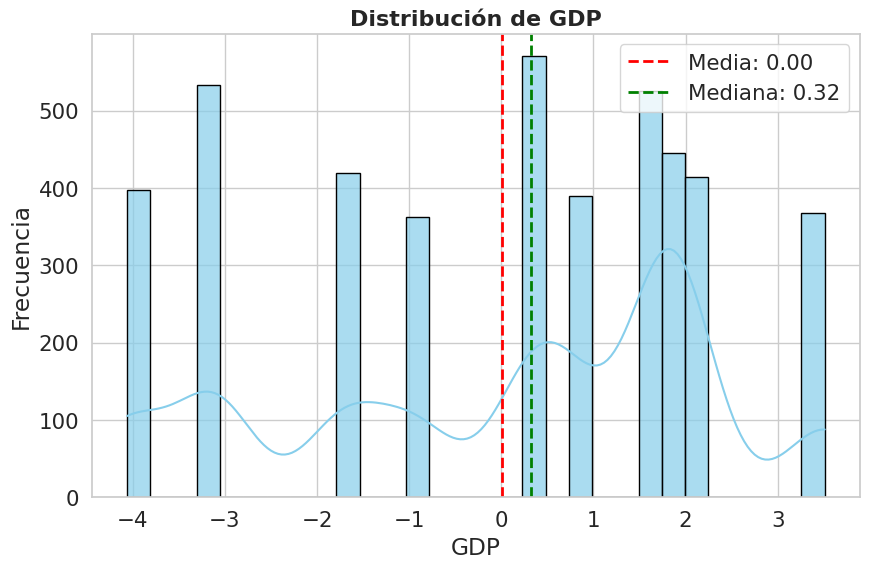

In [11]:
sns.set(style="whitegrid", font_scale=1.4)

plt.figure(figsize=(9, 6))

# histograma + densidad
ax = sns.histplot(data=df, x='GDP', bins=30, kde=True,
                  color='skyblue', edgecolor='black', alpha=0.7)
# título y ejes
plt.title(f'Distribución de GDP', fontsize=16, weight='bold')
plt.xlabel('GDP')
plt.ylabel('Frecuencia')
# estadísticas clave en el gráfico
mean_val = df['GDP'].mean()
median_val = df['GDP'].median()
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_val:.2f}')

plt.legend()
plt.tight_layout()
plt.show()

# Preprocesamiento


# Division de datos

Dividimos los datos 30% test y 70% entrenamiento y proporcionamos el parametro __random_state = 42__ para replicabilidad

In [16]:
X= df.drop(columns=['Estado','GDP'])
Y_Estado=df['Estado']
Y_GDP=df['GDP']
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_Estado, X_test_Estado, Y_train_Estado, Y_test_Estado = train_test_split(X, Y_Estado, test_size=0.3, random_state=42, stratify=Y_Estado)
X_train_GDP, X_test_GDP, Y_train_GDP, Y_test_GDP = train_test_split(X, Y_GDP, test_size=0.3, random_state=42)
print("Clasificación - Estado:")
print("Train:", X_train_Estado.shape, "Test:", X_test_Estado.shape)

print("\nRegresión - GDP:")
print("Train:", X_train_GDP.shape, "Test:", X_test_GDP.shape)

Clasificación - Estado:
Train: (3096, 35) Test: (1328, 35)

Regresión - GDP:
Train: (3096, 35) Test: (1328, 35)


Aqui podemos ver el tamaño de las muestras tanto de entreo como de prueba

# KNN Classifier

In [18]:
K_values= range(1,26)
puntaje_entreno_Estado=[]
puntaje_prueba_Estado=[]
for k in K_values:
    KNclas_model=KNeighborsClassifier(n_neighbors=k)
    KNclas_model.fit(X_train_Estado,Y_train_Estado)
    y_train_pred = KNclas_model.predict(X_train_Estado)
    y_test_pred = KNclas_model.predict(X_test_Estado)
    puntaje_entreno_Estado.append(balanced_accuracy_score(Y_train_Estado, y_train_pred))
    puntaje_prueba_Estado.append(balanced_accuracy_score(Y_test_Estado, y_test_pred))
    

Para el modelo deee **Clasificación** decidimos usar la metrica de **Balanced Accuracy** debido aque la variable respuesta __Estado__ presenta un desbalance en sus clases

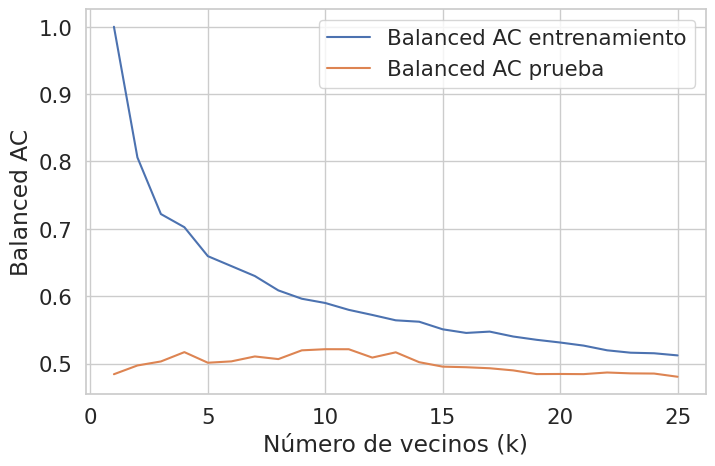

In [19]:

plt.figure(figsize=(8,5))
plt.plot(K_values, puntaje_entreno_Estado, label="Balanced AC entrenamiento")
plt.plot(K_values, puntaje_prueba_Estado, label="Balanced AC prueba")
plt.xlabel("Número de vecinos (k)")
plt.ylabel("Balanced AC")
plt.legend()
plt.show()

Luego de calcular el __Balanced Acurracy score__ para distintos valores de k tomamos el mejor puntaje del teste y nos quedamos con el K que lo obtuvo.
Para este caso decidimos usar además la metrica **f1_score** con el parametro **average='macro'** debido a que consideramos que por el desbalance entre clases que presenta la variable lo mejor seria darle el mismo valor a todas las clases.
Además de generar una matriz de confusión, calcular el ROC (para cada clase) y  el AUC de manera que tengamos una vista más completa del desempeño del modelo.

Mejor k: 10
Balanced Accuracy: 0.5214010782959674
F1-score (macro): 0.5241691496130451


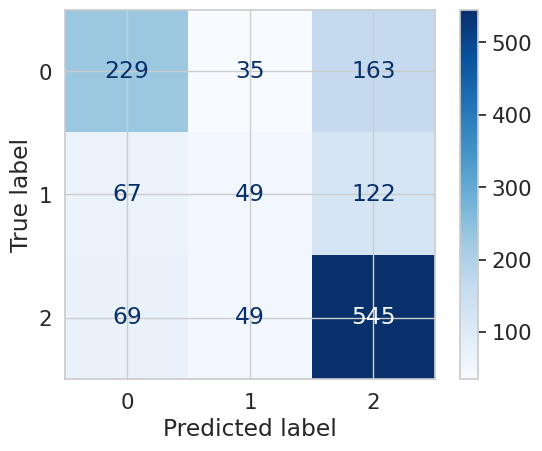

ROC AUC (macro): 0.7160882671315494


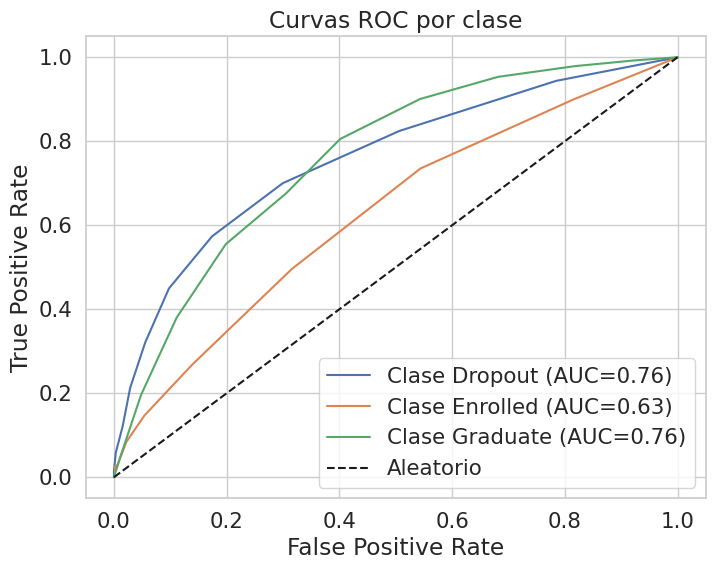

In [20]:
best_k = K_values[puntaje_prueba_Estado.index(max(puntaje_prueba_Estado))]
print(f"Mejor k: {best_k}")

KNclas_model = KNeighborsClassifier(n_neighbors=best_k)
KNclas_model.fit(X_train_Estado, Y_train_Estado)
y_pred = KNclas_model.predict(X_test_Estado)

# Métricas

print("Balanced Accuracy:", balanced_accuracy_score(Y_test_Estado, y_pred))
print("F1-score (macro):", f1_score(Y_test_Estado, y_pred, average='macro'))

cm = confusion_matrix(Y_test_Estado, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

clases = np.unique(Y_Estado)
y_test_bin = label_binarize(Y_test_Estado, classes=clases)
y_score = KNclas_model.predict_proba(X_test_Estado)  # Probabilidades

# Calcular ROC AUC macro
roc_auc_macro = roc_auc_score(y_test_bin, y_score, average='macro', multi_class='ovr')
print("ROC AUC (macro):", roc_auc_macro)

# Dibujar curva ROC para cada clase
plt.figure(figsize=(8,6))
for i, clase in enumerate(clases):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Clase {clase} (AUC={auc_score:.2f})")

# Línea aleatoria
plt.plot([0,1], [0,1], 'k--', label='Aleatorio')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC por clase')
plt.legend()
plt.show()

# KNN Regresion

# Comparación de distintos valores de k

# Documentación y conclusiones